<a href="https://colab.research.google.com/github/emilygrace26/2025_AST4300_Project3/blob/main/Task17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Parameters

#import programs and set general parameters
from astropy.table import Table
from astropy.io import fits
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12


In [ ]:
# Importing MW star data
!wget https://dr19.sdss.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz

# Decompress the gzipped file
!gunzip astraAllStarASPCAP-0.6.0.fits.gz

filename='astraAllStarASPCAP-0.6.0.fits'
tb = fits.open(filename)
header=tb[2].header
data = tb[2].data

--2025-12-05 21:19:45--  https://dr19.sdss.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz
Resolving dr19.sdss.org (dr19.sdss.org)... 155.101.19.134
Connecting to dr19.sdss.org (dr19.sdss.org)|155.101.19.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1171102556 (1.1G) [application/octet-stream]
Saving to: ‘astraAllStarASPCAP-0.6.0.fits.gz.4’

astraAllStarASPCAP- 100%[===================>]   1.09G  47.4MB/s    in 26s     

2025-12-05 21:20:12 (43.1 MB/s) - ‘astraAllStarASPCAP-0.6.0.fits.gz.4’ saved [1171102556/1171102556]

gzip: astraAllStarASPCAP-0.6.0.fits already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
# get rid of stars with negative distances
mask_gaia = (data['zgr_plx']>0)

# use skycoord to input information, correct units
c = SkyCoord(ra=data['ra'][mask_gaia]*u.deg, dec=data['dec'][mask_gaia]*u.deg,
             distance=(data['r_med_geo'][mask_gaia])*u.pc,
             pm_ra_cosdec=data['pmra'][mask_gaia]*u.mas/u.yr,
             pm_dec=data['pmde'][mask_gaia]*u.mas/u.yr,
            radial_velocity=data['v_rad'][mask_gaia]*u.km/u.s)

# transform to galactocentric coordinate
# the assumed values are from Schonrich et al 2010, and from Gravity collab 2022
galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))

In [ ]:
# Extract the galactic coordinates and motions
x = galcen.x.value
y = galcen.y.value
z = galcen.z.value

vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

#galactocentric radius (either in the disk-R or distance from the galactic center)
R = np.sqrt(x**2+y**2)
rgal = np.sqrt(x**2+y**2+z**2)

In [ ]:
#I clipped data table, including the the M/H and alpha/M vectors to the same length as the R and z information first before plotting
data_masked=data[mask_gaia]

In [ ]:
#importing data from Stone-Martinez and Warfield

stonemartinezraw = Table.read('StarFlow_summary_v1_0_0.fits')
warfieldraw = Table.read('Warfield2024.txt', format='ascii')


In [ ]:
#filtering out datapoints without Age value
hasagewarfield=np.where((warfieldraw['Age']==warfieldraw['Age']) & (warfieldraw['Age']>0.0))
warfield=warfieldraw[hasagewarfield]
warfield

EPIC,APOGEE,GaiaEDR3,RAdeg,DEdeg,GLON,GLAT,Rkpc,Zkpc,Teff,Teff-u,e_Teff,logg,logg-u,e_logg,[Fe/H],e_[Fe/H],[a/M],e_[a/M],[O/Fe],e_[O/Fe],aFlag,Mstar,e_Mstar,Rstar,e_Rstar,logg-seis,e_logg-seis,numax,e_numax,deltanu,e_deltanu,Age,e_Age,E_Age,Age-mode,SFW,EvState
,,,deg,deg,deg,deg,kpc,kpc,K,K,K,dex(cm / s2),dex(cm / s2),dex(cm / s2),dex(Sun),dex(Sun),dex(Sun),dex(Sun),dex(Sun),dex(Sun),,solMass,solMass,Rsun,Rsun,dex(cm / s2),dex(cm / s2),uHz,uHz,uHz,uHz,Gyr,Gyr,Gyr,Gyr,,
int64,str18,int64,float64,float64,float64,float64,str6,str6,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,str6,str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str3
211821580,2M08270102+1737253,662088729307609216,126.7543,17.6237,206.812,28.792,10.252,1.306,4795,4696,9,2.43,2.5,0.03,-0.453,0.008,0.094,0.007,0.173,0.02,0,0.92,0.08,9.5,0.26,2.45,0.01,34.4,0.9,4.42,0.01,11.3,3.0,4.1,10.8,4.32,RGB
212434736,2M13572534-1408010,6302108283398593152,209.3556,-14.1336,326.169,45.74,7.504,0.795,4787,4705,9,2.94,2.99,0.02,-0.24,0.007,0.183,0.006,0.252,0.018,1,1.11,0.02,5.66,0.04,2.98,0.0,116.8,0.7,10.56,0.0,7.3,0.5,0.5,7.2,7.43,RGB
212333123,2M13400342-1634554,3605202458865639552,205.0143,-16.5821,319.433,44.726,6.713,2.016,4795,4703,16,2.87,2.95,0.04,-0.383,0.014,0.235,0.011,0.312,0.036,1,0.87,0.06,5.79,0.13,2.85,0.0,87.3,0.7,9.03,0.1,16.8,4.0,5.3,17.5,5.61,RGB
212173678,2M08253330+2334276,678233202137154304,126.3888,23.5743,200.25,30.532,9.024,0.587,4780,4701,8,2.76,2.83,0.02,-0.188,0.007,0.063,0.006,0.103,0.017,0,1.27,0.05,7.56,0.11,2.78,0.0,74.9,0.9,7.31,0.03,4.3,0.6,0.7,4.1,6.53,RGB
213789445,2M19182284-2816172,6759783812391009920,289.5952,-28.2715,9.756,-17.933,6.271,-0.595,4438,4329,7,2.1,2.21,0.02,-0.239,0.009,0.087,0.006,0.124,0.013,0,1.38,0.39,18.24,1.68,2.06,0.03,14.6,1.0,2.04,0.06,3.0,2.1,6.8,2.7,3.24,RGB
212591385,2M13374700-1046588,3616757776317838464,204.4458,-10.783,320.985,50.457,6.843,2.143,4507,4404,13,2.32,2.43,0.03,-0.173,0.014,0.178,0.009,0.226,0.024,1,0.88,0.07,10.42,0.26,2.35,0.01,28.4,0.4,3.78,0.04,18.3,4.6,6.2,17.5,11.17,RGB
210521826,2M04034090+1546195,45403134375970432,60.9204,15.7721,176.149,-26.646,9.781,-0.808,4634,4519,9,2.28,2.36,0.03,-0.361,0.009,0.097,0.007,0.114,0.018,0,1.05,0.14,12.44,0.52,2.27,0.01,23.3,0.5,3.16,0.06,7.5,2.9,4.7,6.4,5.51,RGB
246067499,2M23464240-0751238,2436395519498043520,356.6767,-7.8566,81.44,-65.372,8.085,-0.616,4678,4613,10,2.95,3.06,0.02,0.171,0.009,0.018,0.006,0.034,0.018,0,1.11,0.08,5.3,0.13,3.03,0.0,135.1,0.7,11.67,0.14,9.3,2.3,3.0,9.2,41.76,RGB


In [ ]:
agedata= warfield

In [ ]:
# DR19 & Warfield data line up
intersect, ind_a, ind_b = np.intersect1d(data_masked['sdss4_apogee_id'].data,agedata['APOGEE'].data, return_indices=True)

In [ ]:
fullx = np.dstack([data_masked['teff'][ind_a],data_masked['logg'][ind_a], data_masked['m_h_atm'][ind_a],
                   data_masked['alpha_m_atm'][ind_a], data_masked['c_h'][ind_a], data_masked['n_h'][ind_a]])[0]

fully = np.dstack([agedata['Age'][ind_b]])[0] #for Stone-Martinez 2025

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y

In [ ]:
neurons_per_layer=12
layers=3
iterations=100

In [ ]:
#start with an input layer
inputs = keras.Input(shape=(6,))
#now we add the Dense layers (indicating the previous layer in the brackets following the layer declaration

#change this part if you're changing the number of layers
layer1 =keras.layers.Dense(neurons_per_layer, activation='relu')(inputs)
layer2 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer1)
layer3 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer2)
layer4 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer3)
layer5 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer4)
layer6 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer5)
layer7 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer6)
layer8 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer7)
layer9 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer8)
layer10 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer9)
layer11 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer10)
layer12 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer11)
layer13 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer12)
layer14 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer13)
layer15 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer14)
layer16 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer15)
layer17 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer16)
layer18 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer17)
layer19 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer18)
layer20 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer19)
layer21 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer20)
layer22 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer21)
layer23 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer22)

#then the output layer YOU ALSO HAVE TO MAKE THIS MATCH YOUR NUMBER OF LAYERS
outputs = keras.layers.Dense(1)(layer4)


# then we put that all together in the Model object
model = keras.Model(inputs=inputs, outputs=outputs, name='test')
#and we can print a summary to check it all went to plan
model.summary()

Model: "test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565 (2.21 KB)

 Trainable params: 565 (2.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
tenpercent=len(agedata['Age'][ind_b])//10 #figure out what ten percent of this set of age data is

#last name before M
trainbin=slice(0,-1*tenpercent-1)
testing=slice(-1*tenpercent,-1)


x_train, y_train = fullx[trainbin], fully[trainbin]
x_test, y_test = fullx[testing], fully[testing]

In [ ]:
model.fit(x_train, y_train, epochs=iterations, validation_split=0.05, batch_size=300)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0000e+00 - loss: 2.0109 - val_accuracy: 0.0000e+00 - val_loss: 3.2992
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 1.7046 - val_accuracy: 0.0000e+00 - val_loss: 2.9789
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0011 - loss: 1.4004 - val_accuracy: 0.0000e+00 - val_loss: 2.6012
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0020 - loss: 1.1528 - val_accuracy: 0.0000e+00 - val_loss: 2.1877
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0052 - loss: 0.9322 - val_accuracy: 0.0000e+00 - val_loss: 1.8437
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0070 - loss: 0.7689 - val_accuracy: 0.0000e+00 - val_loss: 1.6739
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0098 - loss: 0.7217 - val_accuracy: 0.0000e+00 - val_loss: 1.6330
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.00

In [ ]:
predictions = model.predict(x_test)
print(len(predictions))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
376


In [ ]:
metric=0.3 #is the accuracy better than 30%?
goodfit=np.where(((1-metric) < predictions/y_test) & ((1+metric) > predictions/y_test))
badfit=np.where(((1-metric) > predictions/y_test) | ((1+metric) < predictions/y_test))

print ('With ', neurons_per_layer, 'neurons per layer, ', layers, 'layers, and ', iterations, 'iterations')
print ('using the training set', trainbin)
print (len(goodfit[0])/len(y_test)*100, 'percent of the ages are good')
print (len(badfit[0])/len(y_test)*100, 'percent of the ages are bad')

With  12 neurons per layer,  3 layers, and  100 iterations
using the training set slice(0, -378, None)
55.053191489361694 percent of the ages are good
44.9468085106383 percent of the ages are bad


(0.0, 14.0)

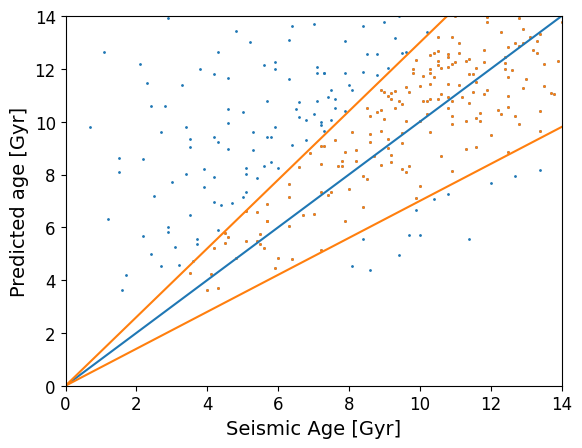

In [ ]:
#scale input/output
plt.scatter( (y_test*scaling_y),(predictions*scaling_y), s=1.)
plt.scatter( (y_test[goodfit]*scaling_y),(predictions[goodfit]*scaling_y), s=1.)
plt.xlim(0.,14.)
plt.plot([0.,14.], [0.,14.])
plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.ylabel(r'Predicted age [Gyr]')
plt.xlabel(r'Seismic Age [Gyr]')
plt.ylim(0,14)

In [ ]:
DR19x = np.dstack([data_masked['teff'],data_masked['logg'], data_masked['m_h_atm'],
                   data_masked['alpha_m_atm'], data_masked['c_h'], data_masked['n_h']])[0]
print(len(data_masked['teff']))

DR19x= DR19x/scaling_x
predictionsDR19 = model.predict(DR19x)

963539
30111/30111 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step


In [ ]:
good=np.where((data_masked['teff'] > 3700) &
    (data_masked['teff'] < 5300) &
    (data_masked['logg'] > 0.9) &
    (data_masked['logg'] < 3.3) &
    (data_masked['m_h_atm'] > -2.0) &
    (data_masked['m_h_atm'] < 0.6))

In [ ]:
#applying y-scaling and getting good predictions
war_predic = predictionsDR19[good]*scaling_y

issues

In [ ]:
APOK2 = stonemartinezraw.to_pandas()
APOK2 = APOK2[APOK2["age"] != -9999.0000] #remove all bad age sources
valid = APOK2[(APOK2["age"] > -1) & (APOK2["age"] < 1.2)].copy() # Use .copy() to avoid SettingWithCopyWarning

valid["Age_Gyr"] = 10**valid["age"]


APOK2

,sdss_id,sdss4_apogee_id,catalogid,age,e_p_age,e_n_age,mass,e_p_mass,e_n_mass,training_density,BITMASK
0,54968703,b'2M03455109+5955388',63050394798264488,5.535536,7.329329,3.713714,0.080051,0.144509,0.001737,1.786528e+10,2
1,116010946,b'2M03455125+3159498',63050396568859167,5.465465,7.497497,3.391391,0.057774,0.121443,-0.016859,1.963289e+10,2
2,114979218,b'2M03521555+1818064',63050396552439324,4.526527,6.418418,2.606607,0.077874,0.136956,0.009470,1.505021e+10,3
3,115031735,b'2M03521570+2245296',63050396552988608,3.223223,5.143143,1.009009,-0.000871,0.146377,-0.238708,8.614447e+08,2
4,114941357,b'2M03521583+1251133',63050396551977516,2.984985,4.442442,1.499499,0.161038,0.224625,0.084372,2.417527e+10,2
...,...,...,...,...,...,...,...,...,...,...,...
1059516,94596811,b'2M03484545-1058335',63050395811882387,NaN,NaN,NaN,-0.003495,0.123413,-0.199790,0.000000e+00,0
1059517,55105597,b'2M03484564+6905141',63050394801274341,14.000000,13.971944,13.158317,0.159232,0.270382,0.004330,6.570968e+06,0
1059518,76059297,b'2M03484598-0604083',63050395128340475,14.000000,13.971944,13.607214,0.125374,0.200625,0.029441,9.323465e-02,0
1059519,116051329,b'2M03484604+3913412',63050396569537105,1.010020,1.935872,0.056112,0.244404,0.302767,0.175220,1.849330e+10,2


In [ ]:
#reducing stonemartinez's data to only the "good" data
hasagestonemartinez=np.where((stonemartinezraw['age']==stonemartinezraw['age']) & (stonemartinezraw['age']>0.0))
stonemartinez=stonemartinezraw[hasagestonemartinez]
stonemartinez

sdss_id,sdss4_apogee_id,catalogid,age,e_p_age,e_n_age,mass,e_p_mass,e_n_mass,training_density,BITMASK
int64,bytes19,int64,float64,float64,float64,float64,float64,float64,float64,int64
54968703,2M03455109+5955388,63050394798264488,5.535535535535535,7.32932932932933,3.7137137137137137,0.0800507047602537,0.1445086939871722,0.0017371802438558,17865277000.0,2
116010946,2M03455125+3159498,63050396568859167,5.465465465465465,7.4974974974974975,3.391391391391392,0.0577743100491014,0.1214433899184787,-0.0168593082478027,19632886000.0,2
114979218,2M03521555+1818064,63050396552439324,4.526526526526527,6.418418418418418,2.6066066066066065,0.0778737855059791,0.1369555560967263,0.0094696304745464,15050214000.0,3
115031735,2M03521570+2245296,63050396552988608,3.2232232232232234,5.143143143143143,1.009009009009009,-0.0008712028636723,0.1463766301222914,-0.238708057864159,861444740.0,2
114941357,2M03521583+1251133,63050396551977516,2.984984984984985,4.4424424424424425,1.4994994994994997,0.1610377516711409,0.22462491236987,0.0843720785428962,24175270000.0,2
115029776,2M03521583+2129049,63050396552967384,5.913913913913914,7.945945945945946,3.867867867867868,0.0508623156327714,0.1134744602472034,-0.0223222039493048,18029144000.0,2
76315157,2M03521608+0923173,63050395130270017,5.297297297297297,7.231231231231231,3.293293293293293,0.0756858993578036,0.1312032272076349,0.0120168194884263,28866870000.0,2
75692016,2M03521610-0953441,63050395125367086,14.0,13.985985985985986,13.92992992992993,0.2841706874161784,0.3778112158593876,0.1646269826945847,5.2839390000000004e-17,0
75687337,2M03521610-1049171,63050395125346019,14.0,13.985985985985986,13.593593593593594,0.1114591690118778,0.221500478160721,-0.0536619561555513,27799.22,0


In [ ]:
from astropy.table import unique

In [ ]:
#getting our predicted ages into a table with corresponding APOGEE ID
t = Table()

t['APOGEE'] = data_masked['sdss4_apogee_id'][good]
t['Age'] = war_predic

In [ ]:
from astropy.table import join
import numpy as np # Ensure numpy is imported

# Ensure sdss4_apogee_id in stonemartinez is clean (no empty byte strings or masked values)
valid_sm_ids_mask = (stonemartinez['sdss4_apogee_id'].data != b'')
if hasattr(stonemartinez['sdss4_apogee_id'].data, 'mask'):
    valid_sm_ids_mask &= (~stonemartinez['sdss4_apogee_id'].data.mask)
stonemartinez_clean = stonemartinez[valid_sm_ids_mask]

# Prepare t for joining by renaming its APOGEE column to match stonemartinez
t_for_join = t.copy()
t_for_join.rename_column('APOGEE', 'sdss4_apogee_id')

# Ensure sdss4_apogee_id in t_for_join is clean
valid_t_ids_mask = (t_for_join['sdss4_apogee_id'].data != b'')
if hasattr(t_for_join['sdss4_apogee_id'].data, 'mask'):
    valid_t_ids_mask &= (~t_for_join['sdss4_apogee_id'].data.mask)
t_for_join_clean = t_for_join[valid_t_ids_mask]

# Perform an inner join on the common APOGEE ID
merged_ages = join(stonemartinez_clean, t_for_join_clean, keys='sdss4_apogee_id', join_type='inner')

# Now, l_sort and p_sort can refer to this merged table, ensuring alignment
l_sort = merged_ages
p_sort = merged_ages

In [ ]:
# The sorting is now handled implicitly by the join operation. We just need to make sure l_sort and p_sort are the merged_ages table.
# To keep the variable names consistent with later cells:
# l_sort and p_sort are already assigned from merged_ages in the previous cell.

In [ ]:
# The sorting is now handled implicitly by the join operation. We just need to make sure l_sort and p_sort are the merged_ages table.
# To keep the variable names consistent with later cells:
# l_sort and p_sort are already assigned from merged_ages in the previous cell.

In [ ]:
# The 'Age' column from the join might be 2D (N,1), flatten it to a 1D array
# Check if 'Age' column exists and needs flattening
if 'Age' in p_sort.colnames and p_sort['Age'].ndim > 1:
    p_sort['Age'] = p_sort['Age'].flatten()

Length of Stone-Martinez ages (finite): 362748
Length of Predicted ages (finite): 362748


Text(0, 0.5, 'Δ Age [Gyr]')

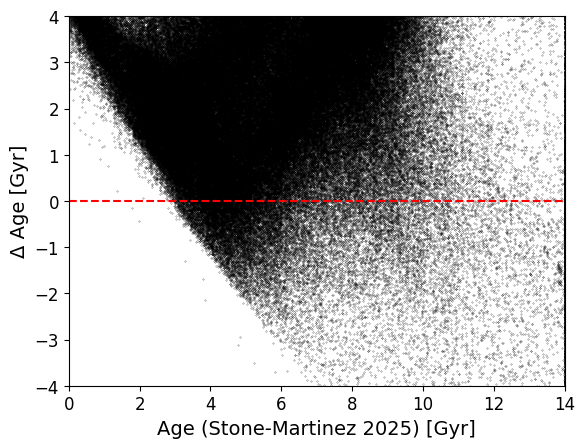

In [ ]:
age_sm = l_sort['age'].data.flatten() # Get the underlying data array and flatten
age_pred = p_sort['Age'].data.flatten() # Get the underlying data array and flatten

# Ensure both are finite before attempting subtraction
# Find indices where both arrays have finite values
finite_mask = np.isfinite(age_sm) & np.isfinite(age_pred)

age_sm_finite = age_sm[finite_mask]
age_pred_finite = age_pred[finite_mask]

print(f"Length of Stone-Martinez ages (finite): {len(age_sm_finite)}")
print(f"Length of Predicted ages (finite): {len(age_pred_finite)}")

d_age = age_pred_finite - age_sm_finite
plt.figure()
plt.scatter(age_sm_finite, d_age, s=0.05, color = 'black', alpha=0.8)
plt.plot([0, 14], [0, 0], linestyle = '--', color = 'red')
plt.xlim(0, 14)
plt.ylim(-4, 4)
plt.xlabel('Age (Stone-Martinez 2025) [Gyr]')
plt.ylabel('Δ Age [Gyr]')

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


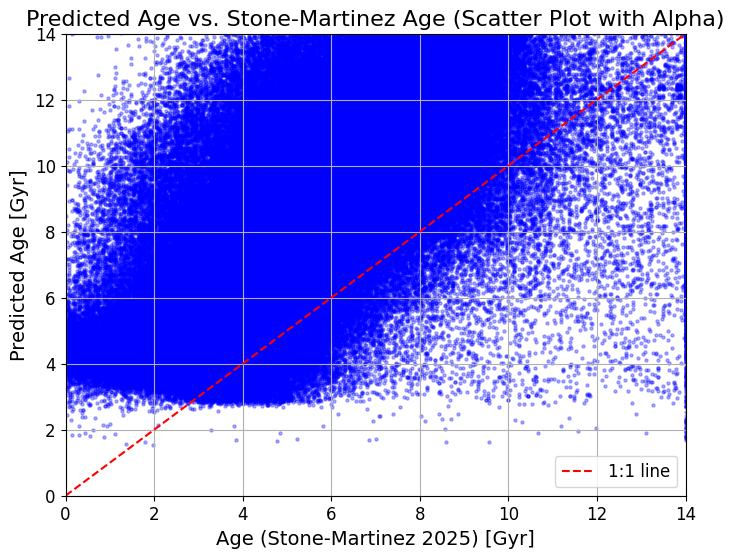

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(age_sm_finite, age_pred_finite, s=5, alpha=0.3, color='blue')
plt.plot([0, 14], [0, 14], color='red', linestyle='--', label='1:1 line')
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.xlabel('Age (Stone-Martinez 2025) [Gyr]')
plt.ylabel('Predicted Age [Gyr]')
plt.title('Predicted Age vs. Stone-Martinez Age (Scatter Plot with Alpha)')
plt.legend()
plt.grid(True)
plt.show()

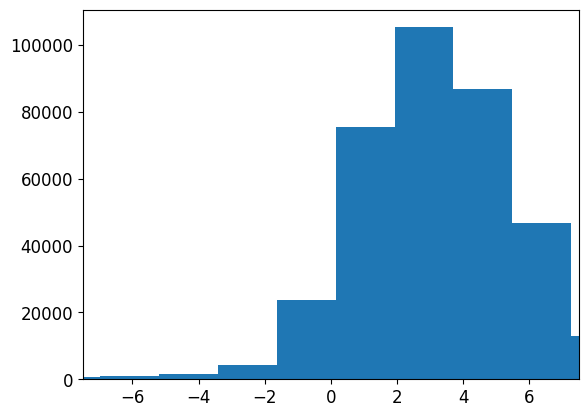

In [ ]:
plt.hist(d_age, bins = 30)
plt.xlim(-7.5, 7.5)
plt.show()